In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler

device = torch.device("mps" if torch.mps.is_available() else "cpu")

In [2]:
df = pd.read_csv('fall_pose_keypoint.csv')
df.head()

,image_name,label,nose_x,nose_y,left_eye_x,left_eye_y,right_eye_x,right_eye_y,left_ear_x,left_ear_y,...,right_hip_x,right_hip_y,left_knee_x,left_knee_y,right_knee_x,right_knee_y,left_ankle_x,left_ankle_y,right_ankle_x,right_ankle_y
0,depositphotos_245876718-stock-photo-senior-man...,not-fall,0.485839,0.410512,0.495773,0.394320,0.477423,0.389139,0.508761,0.388049,...,0.436837,0.600978,0.512779,0.606168,0.414417,0.604592,0.465867,0.797919,0.399739,0.786769
1,download (5).jpeg,not-fall,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.598155,0.194260,...,0.630579,0.438007,0.598843,0.579984,0.629291,0.577627,0.610139,0.726956,0.633059,0.714906
2,man-sitting-on-floor-next-to-couch-dirtier-tha...,not-fall,0.607777,0.382062,0.630249,0.331423,0.585865,0.330294,0.668024,0.313463,...,0.540982,0.965722,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,3008.jpg,not-fall,0.597149,0.269850,0.640758,0.237419,0.592207,0.213645,0.726758,0.251189,...,0.603001,0.865304,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,3020.jpg,not-fall,0.320964,0.260311,0.333139,0.227619,0.298050,0.230738,0.000000,0.000000,...,0.253200,0.676568,0.510862,0.631657,0.313992,0.694880,0.408492,0.859661,0.215078,0.917820


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 546 entries, 0 to 545
Data columns (total 36 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   image_name        546 non-null    object 
 1   label             546 non-null    object 
 2   nose_x            546 non-null    float64
 3   nose_y            546 non-null    float64
 4   left_eye_x        546 non-null    float64
 5   left_eye_y        546 non-null    float64
 6   right_eye_x       546 non-null    float64
 7   right_eye_y       546 non-null    float64
 8   left_ear_x        546 non-null    float64
 9   left_ear_y        546 non-null    float64
 10  right_ear_x       546 non-null    float64
 11  right_ear_y       546 non-null    float64
 12  left_shoulder_x   546 non-null    float64
 13  left_shoulder_y   546 non-null    float64
 14  right_shoulder_x  546 non-null    float64
 15  right_shoulder_y  546 non-null    float64
 16  left_elbow_x      546 non-null    float64
 1

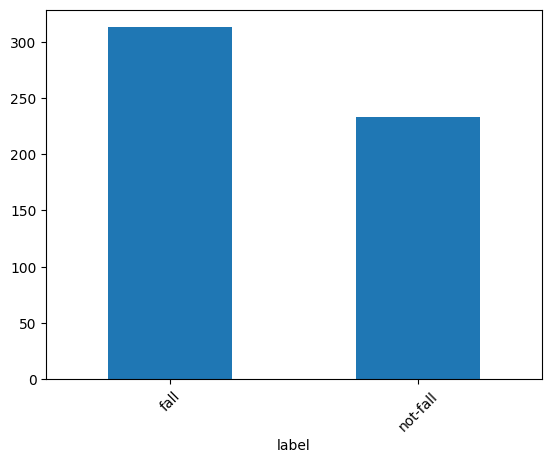

In [4]:
df.label.value_counts().plot(kind="bar")
plt.xticks(rotation=45)
plt.show()

In [5]:
encoder = LabelEncoder()
y_label = df['label']
y = encoder.fit_transform(y_label)
y

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [6]:
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y), y=y)
class_weights

array([0.87220447, 1.17167382])

In [10]:
X = df.iloc[:,12:]
X

,left_shoulder_x,left_shoulder_y,right_shoulder_x,right_shoulder_y,left_elbow_x,left_elbow_y,right_elbow_x,right_elbow_y,left_wrist_x,left_wrist_y,...,right_hip_x,right_hip_y,left_knee_x,left_knee_y,right_knee_x,right_knee_y,left_ankle_x,left_ankle_y,right_ankle_x,right_ankle_y
0,0.534824,0.444538,0.423839,0.436997,0.546437,0.539332,0.401373,0.537893,0.516947,0.566562,...,0.436837,0.600978,0.512779,0.606168,0.414417,0.604592,0.465867,0.797919,0.399739,0.786769
1,0.585692,0.265534,0.636859,0.259358,0.559001,0.358133,0.669974,0.347982,0.542718,0.438788,...,0.630579,0.438007,0.598843,0.579984,0.629291,0.577627,0.610139,0.726956,0.633059,0.714906
2,0.736637,0.498279,0.490937,0.514325,0.795259,0.789487,0.438259,0.824723,0.748976,0.879148,...,0.540982,0.965722,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.799819,0.394216,0.537067,0.384085,0.839693,0.728650,0.493323,0.699068,0.671273,0.815322,...,0.603001,0.865304,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.377460,0.300484,0.197641,0.357846,0.470625,0.302354,0.179517,0.542965,0.599963,0.303633,...,0.253200,0.676568,0.510862,0.631657,0.313992,0.694880,0.408492,0.859661,0.215078,0.917820
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
541,0.485192,0.822922,0.392715,0.828087,0.627415,0.945913,0.000000,0.000000,0.556014,0.851447,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
542,0.583668,0.520447,0.532959,0.558943,0.592275,0.525042,0.511910,0.604531,0.550360,0.520461,...,0.540486,0.681675,0.515760,0.663084,0.458586,0.670943,0.435092,0.745804,0.362407,0.748630
543,0.419663,0.652873,0.373191,0.641693,0.444414,0.699178,0.369516,0.681932,0.486647,0.667621,...,0.362456,0.725952,0.484129,0.755268,0.370119,0.770864,0.458609,0.866820,0.284128,0.897199
544,0.662146,0.645872,0.674073,0.619589,0.560790,0.740320,0.573328,0.704465,0.472588,0.851524,...,0.443808,0.632817,0.291611,0.488406,0.279879,0.460175,0.234313,0.579899,0.223537,0.538695


In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, shuffle=True, random_state=2022)

print("Number of Training keypoints: ", len(X_train))
print("Number of Testing keypoints: ", len(X_test))

Number of Training keypoints:  436
Number of Testing keypoints:  110


In [12]:
scaler = MinMaxScaler()

In [13]:
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_test

array([[0.49680482, 0.85462891, 0.47675337, ..., 0.90121424, 0.96241667,
        0.94192106],
       [0.3941038 , 0.54857019, 0.41727446, ..., 0.50727826, 0.63990587,
        0.55852294],
       [0.759682  , 0.52781039, 0.75362635, ..., 0.9871787 , 0.71293029,
        0.9787571 ],
       ...,
       [0.85106766, 0.34488609, 0.65875393, ..., 0.8447918 , 0.56890732,
        0.8466833 ],
       [0.44007042, 0.59896685, 0.3402254 , ..., 0.        , 0.        ,
        0.        ],
       [0.38874752, 0.72504629, 0.46934833, ..., 0.42011213, 0.55036736,
        0.42547867]])

In [14]:
class DataKeypointClassification(Dataset):
    def __init__(self, X, y):
        self.x = torch.from_numpy(X.astype(np.float32))
        self.y = torch.from_numpy(y.astype(np.int64))
        self.n_samples = X.shape[0]
    
    def __getitem__(self, index):
        return self.x[index], self.y[index]
    
    def __len__(self):
        return self.n_samples

In [15]:
train_dataset = DataKeypointClassification(X_train, y_train)
test_dataset = DataKeypointClassification(X_test, y_test)

In [16]:
batch_size = 12
train_loader = DataLoader(train_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [17]:
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.l1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.l2 = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
        out = self.l1(x)
        out = self.relu(out)
        out = self.l2(out)
        return out

In [34]:
hidden_size = 256
model = NeuralNet(X_train.shape[1], hidden_size, len(class_weights))
print(X_train.shape[1])

24


In [19]:
len(class_weights)

2

In [20]:
learning_rate = 0.01
criterion = nn.CrossEntropyLoss(weight=torch.from_numpy(class_weights.astype(np.float32)))
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [21]:
num_epoch = 40
for epoch in range(num_epoch):
    train_acc = 0
    train_loss = 0
    loop = tqdm(train_loader)
    for idx, (features, labels) in enumerate(loop):
        outputs = model(features)
        loss = criterion(outputs, labels)

        predictions = outputs.argmax(dim=1, keepdim=True).squeeze()
        correct = (predictions == labels).sum().item()
        accuracy = correct / batch_size
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loop.set_description(f"Epoch [{epoch}/{num_epoch}]")
        loop.set_postfix(loss=loss.item(), acc=accuracy)

Epoch [38/40]:   0%|          | 0/37 [00:00<?, ?it/s, acc=0.667, loss=0.673]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [22]:
test_features = torch.from_numpy(X_test.astype(np.float32))
test_labels = y_test
with torch.no_grad():
    outputs = model(test_features)
    _, predictions = torch.max(outputs, 1)
predictions

tensor([0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1,
        1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1,
        0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1,
        0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1,
        1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0])

In [23]:
print(classification_report(test_labels, predictions, target_names=encoder.classes_))

              precision    recall  f1-score   support

        fall       0.88      0.92      0.90        63
    not-fall       0.89      0.83      0.86        47

    accuracy                           0.88       110
   macro avg       0.88      0.88      0.88       110
weighted avg       0.88      0.88      0.88       110



In [27]:
PATH_SAVE = '../../../../../data/weights/yolo_pose_nnClassifier/pose_classification.pt'
torch.save(model.state_dict(), PATH_SAVE)

In [28]:
model_inference =  NeuralNet(
        X_train.shape[1], 
        hidden_size, 
        len(class_weights)
    )

model_inference.load_state_dict(
        torch.load(PATH_SAVE, map_location=device)
    )

/var/folders/f6/cqgl3gc517zb0rzw3ms24b9r0000gn/T/ipykernel_86703/1259055062.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(PATH_SAVE, map_location=device)


<All keys matched successfully>

In [33]:
feature, label = test_dataset.__getitem__(104)

out = model_inference(feature)
_, predict = torch.max(out, -1)
print(f'\
    prediction label : {encoder.classes_[predict]} \n\
    ground thrut label : {encoder.classes_[label]}'
    )

    prediction label : not-fall 
    ground thrut label : not-fall
